# YOLO Prediction

## Load pretrained model

In [31]:
from keras.models import load_model, Model
from keras.layers import Input
from keras import backend as K
import numpy as np
from yolo_model import yolo_model
from utils import box_iou, letterbox_image, read_anchors, draw_bbox

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
anchors = read_anchors('model/yolo_anchors.txt')
num_anchors = 3

In [6]:
inputs = Input((416, 416, 3))
y1, y2, y3 = yolo_model(inputs, num_anchors, 2)
model = Model(inputs, [y1, y2, y3])
model.load_weights('model/yolo_train.h5')

In [7]:
print(model.output[0].shape, model.output[1].shape, model.output[2].shape)

(?, 13, 13, 21) (?, 26, 26, 21) (?, 52, 52, 21)


## Boxes Processing

Implemented with numpy for easyly understanding.

### An example of grid:  
* box_xy + grid == (box_x + col_index) and (box_y + row_index)

In [8]:
h, w = 5, 4
col_index = np.tile(np.arange(0, w), h).reshape(h, w)
print(col_index)
row_index = np.tile(np.arange(0, h).reshape(h, 1), w)
print(row_index)
grid = np.concatenate((col_index.reshape(h, w, 1), row_index.reshape(h, w, 1)), axis=-1)
print(grid.shape)

[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]
[[0 0 0 0]
 [1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]
 [4 4 4 4]]
(5, 4, 2)


In [9]:
import math

def sigmoid(x):
    return 1 / (1 + math.e ** -x)

def gen_grid(h, w, num_anchors):
    """generate grid of shape(h, w, num_anchors, 2)"""
    col_index = np.tile(np.arange(0, w), h).reshape(h, w)
    row_index = np.tile(np.arange(0, h).reshape(h, 1), w)
    grid = np.concatenate((col_index.reshape(h, w, 1, 1), row_index.reshape(h, w, 1, 1)), axis=-1)
    grid = grid.repeat(3, axis=-2)
    return grid

### Calculate box left_top and right_bottom corners' cordinates, box scores:

In [10]:
def feats_to_boxes(feats, anchors, num_classes, image_wh):
    """
    Arguments:
        feats: model output of one layer one image, shape(1, h, w, num_anchors*(num_classes+5)).
        anchors: anchor boxe size array, shape(num_anchors, 2).
        num_classes: total class num.
        image_wh: true input image size of (w, h).
    """
    input_size = [416, 416]
    h, w = feats.shape[1:3]
    num_anchors = len(anchors)
    
    grid = gen_grid(h, w, num_anchors)
    feats = feats.reshape(h, w, num_anchors, num_classes+5)
    
    box_xy = sigmoid(feats[..., :2])  # box center offset to grid left top corner, range(0, 1), rate to grid size.
    box_wh = math.e ** feats[..., 2:4]  # zoom ratio of anchor size, range(0, inf).
    box_confidence = sigmoid(feats[..., 4:5])  # probability of being object, range(0, 1).
    box_class_probs = sigmoid(feats[..., 5:])  # probability of each class, range(0, 1).
    
    box_xy += grid  # (box_x + col_index) and (box_y + row_index), box_xy position from left top, rate to w, h.
    box_xy /= [w, h]  # normalize box_xy position, range(0, 1), rate to (416, 416).
    
    box_wh *= anchors.reshape(1, 1, num_anchors, 2)  # true size of bbox w, h.
    box_wh /= input_size  # normalize box_wh to range(0, 1), rate to (416, 416).
    
    # map box data back to image size rate. Image size transfer func: letterbox_image, zoom->padding.
    zoom_scale = min(input_size[0]/image_wh[0], input_size[1]/image_wh[1])
    image_wh = np.array(image_wh)
    nopadding_wh = np.round(image_wh * zoom_scale)  # w,h==416 or one of w,h < 416.
    padding_offset = (input_size - nopadding_wh)//2  # padding to 416.
    padding_offset /= input_size  # normalize to range(0, 1).
    
    padding_scale = input_size/nopadding_wh
    box_xy = (box_xy - padding_offset) * padding_scale  # range(0, 1) rate to nopadding_wh image.
    box_wh *= padding_scale  # range(0, 1) rate to nopadding_wh image.
    
    # calculate box cordinates in range(0, 1).
    box_left_top = box_xy - box_wh/2
    box_right_bottom = box_xy + box_wh/2
    
    # scale back to range(0, image_wh).
    box_left_top *= image_wh
    box_right_bottom *= image_wh
    
    # concatenate return values.
    boxex = np.concatenate((box_left_top, box_right_bottom), axis=-1).reshape((-1, 4))
    box_scores = (box_confidence * box_class_probs).reshape((-1, num_classes))
    
    return boxex, box_scores

### Filter and Non Max Suppression:

In [11]:
def filter_and_nms(boxes, box_scores, score_threshold, iou_threshold):
    # filter
    box_classes = np.argmax(box_scores, axis=-1)  # shape(num_boxes)
    box_class_scores = np.max(box_scores, axis=-1)  # shape(num_boxes)
    pos = np.where(box_class_scores >= score_threshold)

    boxes = boxes[pos]  # shape(num_boxes, 4)
    classes = box_classes[pos]  # shape(num_boxes)
    scores = box_class_scores[pos]  # shape(num_boxes)
    
    # nms.
    num_classes = box_scores.shape[-1]
    
    out_boxes = []
    out_classes = []
    out_scores = []
    for c in range(num_classes):
        pos = np.where(classes == c)
        _boxes = boxes[pos]
        _scores = scores[pos]
        _classes = classes[pos]
    
        score_order = _scores.argsort()[::-1]
        out_index = []
        while score_order.size:
            i = score_order[0]
            out_index.append(i)
            iou = box_iou(_boxes[i].reshape(1, -1), _boxes)
            pos = np.where(iou < iou_threshold)
            score_order = score_order[pos]
            
        out_boxes.append(_boxes[out_index])
        out_classes.append(_classes[out_index])
        out_scores.append(_scores[out_index])
        
    out_boxes = np.concatenate(out_boxes)
    out_classes = np.concatenate(out_classes)
    out_scores = np.concatenate(out_scores)
    
    return out_boxes, out_scores, out_classes

### Prediction and draw bbox:

In [12]:
def yolo_predict(feats, anchors, num_classes, image_wh, score_threshold=0.6, iou_threshold=0.5):
    """
    Arguments:
        feats: list of model outputs of one image, each layer shape(1, h, w, num_anchors*(num_classes+5)).
        anchors: anchor boxe size array, shape(num_anchors, 2).
        num_classes: total class num.
        image_wh: true input image size of (w, h).
    """
    # get boxes by iterating 3 output layers.
    boxes = []
    box_scores = []
    for i in range(3):
        _boxes, _box_scores = feats_to_boxes(feats[i], anchors[6-3*i:9-3*i], num_classes, image_wh)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
        
    boxes = np.concatenate(boxes)
    box_scores = np.concatenate(box_scores)
    
    # nms.
    boxes, scores, classes = filter_and_nms(boxes, box_scores, score_threshold, iou_threshold)
    
    return boxes, scores, classes

## Predict

In [13]:
import cv2 as cv
import matplotlib.pyplot as plt
import random

### Prepare data:

(416, 416, 3)
(500, 394, 3)


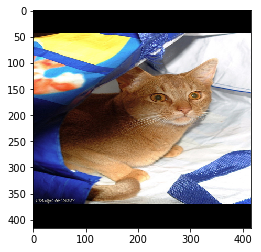

In [39]:
def read_img(path):
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    boxed_image = letterbox_image(image, (416, 416))
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    plt.imshow(boxed_image)
    print(boxed_image.shape)
    
    return image, image_data

# read image
image, image_data = read_img('E:/data/The Oxford-IIIT Pet Dataset/images/Abyssinian_100.jpg')
print(image.shape)

# read class name
class_names = ['cat', 'dog']

In [26]:
sess = K.get_session()
feats = sess.run(model.output, feed_dict={model.input: image_data, K.learning_phase(): 0})
print(feats[0].shape, feats[1].shape, feats[2].shape)

(1, 13, 13, 21) (1, 26, 26, 21) (1, 52, 52, 21)


In [28]:
out_boxes, out_scores, out_classes = yolo_predict(feats, anchors, len(class_names), image.shape[:2], score_threshold=0., iou_threshold=0.)

In [29]:
print(out_boxes)

[[259.41169634  56.97024645 331.362959   264.83964052]
 [ 21.40977234  29.51535463 114.84576017 205.98668539]]


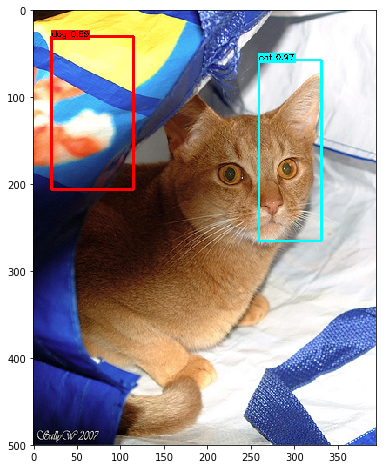

In [40]:
draw_bbox(image, class_names, out_boxes, out_scores, out_classes)